## Manuscript Caffeine Analysis
This notebook shows a meta-analysis of "caffeine clearance rates vs.dosage" and stratifed into three subgroups. All is publicly available on www.pk-db.com/api/v1/.   

The notebook is structured into three parts. 
1. data pooling
2. data inference
3. data visualization

In [1]:
# import libraries
# for the matter for conciseness basic func

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import seaborn as sns
from manuscript import get_data, PKData, filter_out, convert_unit
from copy import deepcopy
from analysis import PlotCategory, create_plots

# 1. Data Pooling 

In [3]:
url = "https://develop.pk-db.com/"
login = {"user": "janekg", "password": "pkdb_deploy"}




base_format = {"format":"json","page_size":1000}
subject_params = {"healthy":"Y"} # not working
output_params = {"normed":"true", "measurement_type":"clearance","substance":"caffeine"}
intervention_params = {"normed":"true", "application":"single dose","substance":"caffeine","tissue":"plasma"} # this search is not working check why

query_params = {
    "outputs":{**base_format, **output_params},
    "interventions":{**base_format, **intervention_params},
    "individuals":{**base_format,**subject_params},
    "groups":{**base_format,**subject_params}
    }


In [4]:
pk_dict = {}
for query, params in query_params.items():
    print(f"load {query}")
    pk_dict[query] = get_data(url,query,login=login, **params)
                                   
    

load outputs
load interventions
load individuals
load groups


In [5]:
pk_data = PKData(**deepcopy(pk_dict))


In [6]:
pk_data.format()

In [7]:
pk_data.merge()


/home/janekg/Env/pkdb_analysis/local/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/janekg/Env/pkdb_analysis/local/lib/python3.6/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [8]:
pk_data.outputs_m = filter_out(pk_data.outputs_m,"tissue",["saliva"])


In [9]:
pk_data.outputs_m = pk_data.outputs_m[pk_data.outputs_m[("healthy","choice")] == "Y"]

In [10]:
pk_data.outputs_m.loc[(pk_data.outputs_m[("sex","choice")] == "M"),("oral contraceptives","choice")] = "N"
pk_data.outputs_m = filter_out(pk_data.outputs_m,"unit",["milliliter / meter ** 2 / minute"])

In [11]:
pk_data.outputs_m["outlier"] = False
pk_data.outputs_m.groupby(["form"]).apply(len)
pk_data.outputs_m.groupby(["route"]).apply(len)


route
iv       15
oral    739
dtype: int64

In [12]:
pk_data.infer_from_interventions()




/home/janekg/Env/pkdb_analysis/local/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [13]:
pk_data.infer_from_outputs()

In [14]:
colors = sns.color_palette("colorblind",n_colors=5) 
def outlier_idx(data):
    return  data.outlier == True 

def control_idx_strict(data):
    return ( data[('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'Y') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data) & ~oc_smoking_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))

categories_strict = [
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx_strict),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx_strict),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx_strict),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="OC-SMOKING", color=colors[1], marker='o', data_idx=oc_smoking_strict),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [15]:
def capsule_idx(data):
    return  data.form == "capsule" 
def no_info_idx(data):
    return  data.form == "no info" 

def solution_idx(data):
    return  data.form == "solution" 

def tablet_idx(data):
    return  data.form == "tablet" 

def iv_idx(data):
    return  data.route == "iv" 

In [16]:
categories_form = [
    PlotCategory(name="capsule", color="darkgray", marker='o', data_idx=capsule_idx),
    PlotCategory(name="no info", color=colors[2], marker='o', data_idx=no_info_idx),
    PlotCategory(name="solution", color=colors[0], marker='o', data_idx=solution_idx),
    PlotCategory(name="tablet", color=colors[3], marker='o', data_idx=tablet_idx),
    PlotCategory(name="outlier", color='red', marker='x', data_idx=iv_idx),

    ]

In [17]:
pk_data.outputs_m.loc[pk_data.outputs_m["study"]== "Balogh1992","outlier"] = True
pk_data.outputs_m.loc[pk_data.outputs_m["study"]== "Harder1988","outlier"] = True
pk_data.outputs_m.loc[pk_data.outputs_m["study"]== "Harder1989","outlier"] = True    
pk_data.outputs_m.loc[pk_data.outputs_m["study"]== "Stille1987","outlier"] = True

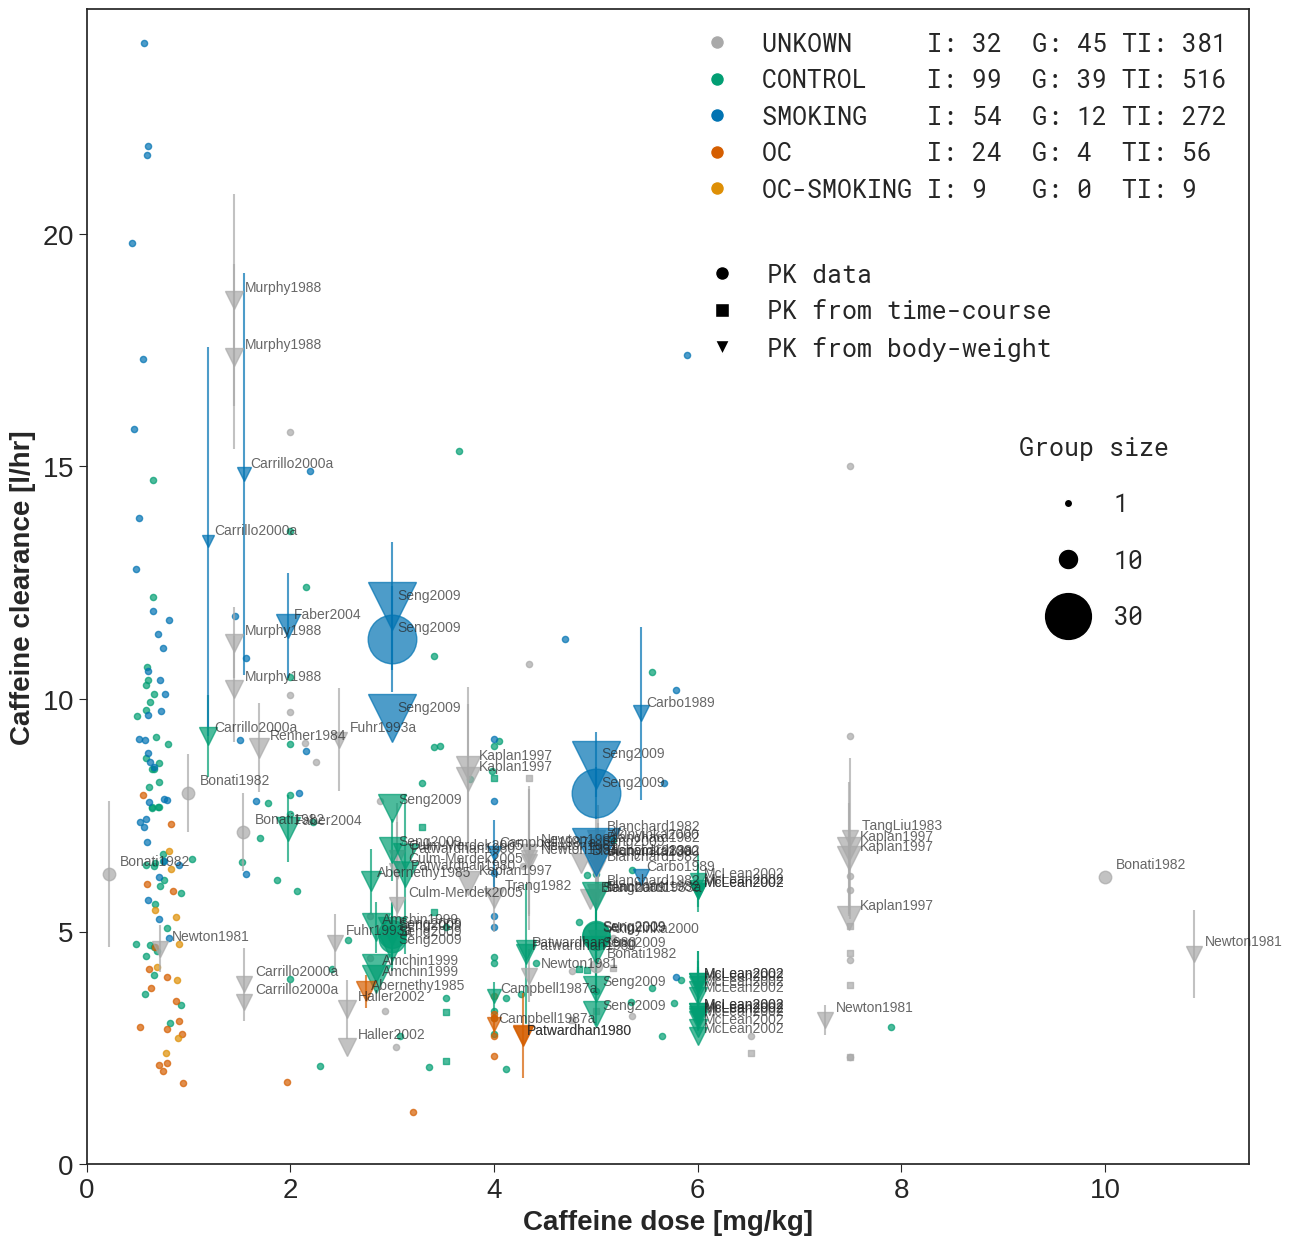

In [78]:
create_plots(pk_data.outputs_m,categories_strict,".")
